# NN Image Classification

In [ ]:
! mkdir models
! mkdir pics

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial
from tabulate import tabulate
import seaborn as sns
sns.set(style='whitegrid')

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Training and Evaluation Utilites

In [ ]:
def param_count(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def train(network, train_loader, criterion, optimizer, epoch,
          log_interval, train_losses, train_counter):
  network.train() # read docs
  for batch_idx, batch in enumerate(train_loader):
    data, target = batch[0].to(device), batch[1].to(device)

    optimizer.zero_grad()
    output = network(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size_train)+((epoch-1)*len(train_loader.dataset)))

In [ ]:
def test(network, test_loader, criterion, test_accurs=None, test_losses=None):
  test_loss = 0
  correct = 0

  network.eval() # read docs
  with torch.no_grad():
    for batch in test_loader:
      data, target = batch[0].to(device), batch[1].to(device)
      output = network(data)
      test_loss += criterion(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  
  test_loss /= len(test_loader.dataset)
  if test_losses is not None:
    test_losses.append(test_loss)
  
  test_accur = correct / len(test_loader.dataset)
  if test_accurs is not None:
    test_accurs.append(test_accur.cpu())
  
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset), 100. * test_accur))

In [ ]:
def plot(n_epochs, loss_scale, savefig, title, train_losses,
         train_counter, test_losses, test_counter, test_accurs, timers):

  fig, axes = plt.subplots(1, 2, figsize=(12,4))
  fig.tight_layout(pad=3)

  # loss
  k = len(test_losses)
  axes[0].plot(train_counter, train_losses,
               label='Train Loss', color='tab:blue', lw=2)
  axes[0].plot(test_counter, test_losses, lw=2,
               label='Test Loss', color='tab:orange', marker='o')
  axes[0].set_xticks(test_counter)
  axes[0].set_xticklabels(range(1,n_epochs+1))
  axes[0].set_xlabel('epochs completed', fontsize=16)
  axes[0].set_ylabel('loss', fontsize=16)
  axes[0].set_yscale(loss_scale)
  axes[0].legend()

  # accuracy(time)
  axes[1].plot(timers, test_accurs, lw=2,
               color='tab:green', marker='o')
  axes[1].set_xlabel('time, s', fontsize=16)
  axes[1].set_ylabel('accuracy', fontsize=16)

  plt.suptitle(title + " (max accuracy {:2.2f}%, time {:.0f} s)".format(
      max(test_accurs)*100, timers[-1]), fontsize=16)
  
  if savefig:
    plt.savefig('pics/' + title + '.svg', bbox_inches='tight')
  plt.show()

In [ ]:
def train_test_plot(network, n_epochs, criterion, optimizer,
                    train_loader, test_loader, scheduler=None,
                    title='', filename='', savemodel=True, loss_scale='linear',
                    savefig=True, visualise=True, log_interval=100):
  # train history
  train_losses = []
  train_counter = []
  test_accurs = []
  test_losses = []
  timers = []

  # train
  test(network, test_loader, criterion)
  start = time()
  for epoch in range(1, n_epochs + 1):
    train(network, train_loader, criterion, optimizer, epoch,
          log_interval, train_losses, train_counter)
    test(network, test_loader, criterion, test_accurs, test_losses)
    if scheduler is not None:
      scheduler.step()
    
    if savemodel and test_accurs[-1] >= max(test_accurs):
      torch.save(network.state_dict(), f'models/net_{filename}.pth')
      torch.save(optimizer.state_dict(), f'models/opt_{filename}.pth')
      
    end = time()
    timers.append(end-start)
    start = time()

  timers = np.cumsum(timers)
  test_counter = [i*len(train_loader.dataset) for i in range(1,n_epochs+1)]
  result = (train_losses, train_counter, test_losses,
            test_counter, test_accurs, timers)

  if visualise:
    plot(n_epochs, loss_scale, savefig, title, *result)

  return result

**пересылка датасета на cuda не занимает слишком много времени? воспользоваться профайлером, чтобы узнать это?**

## MNIST Dataset

### Prepare Data

In [ ]:
def load_mnist(train, transform):
  return torchvision.datasets.MNIST(
    root='./data', train=train, transform=transform, download=True)

In [ ]:
ordinary_transform = transforms.Compose([transforms.ToTensor()])

train_mnist_tmp = load_mnist(True, ordinary_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_mnist_tmp.data.shape, train_mnist_tmp.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [ ]:
mnist = torch.empty((60000, 28, 28))
for i, (img, target) in enumerate(train_mnist_tmp):
  mnist[i] = img

In [ ]:
mnist.mean(), mnist.std()

(tensor(0.1307), tensor(0.3081))

In [ ]:
my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_mnist = load_mnist(True, my_transform)
test_mnist = load_mnist(False, my_transform)

In [ ]:
batch_size_train = 64
batch_size_test = 1000

train_mnist_loader = torch.utils.data.DataLoader(
  dataset=train_mnist, batch_size=batch_size_train, shuffle=True)

test_mnist_loader = torch.utils.data.DataLoader(
  dataset=test_mnist, batch_size=batch_size_test, shuffle=True)

### Fully Connected Layers

In [ ]:
# optimizer1 = partial(optim.SGD, lr=0.001, momentum=0.9)
optimizer1 = optim.Adam

#### Logistic Regression, 8K params

In [ ]:
class LogReg(nn.Module):
  def __init__(self):
    super().__init__()

    # 7840 params
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 10)
    )

  def forward(self, x):
    return self.layers(x)

**зачем нужны группы параметров?**

**некоторые оптимизаторы требуют увеличение шага с каждой эпохой? adagrad такой?**

**затестить бы lbfgs, чтобы убедиться что он плох для нейросетей**


Test set: Avg. loss: 2.4529, Accuracy: 1202/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.489214
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.426927
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.459477
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.232648
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.414489
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.337207
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.674316
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.343505
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.476687
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.522322

Test set: Avg. loss: 0.2882, Accuracy: 9165/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.368254
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.265396
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.157964
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.202962
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.238779
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.291659
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.292478
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.549

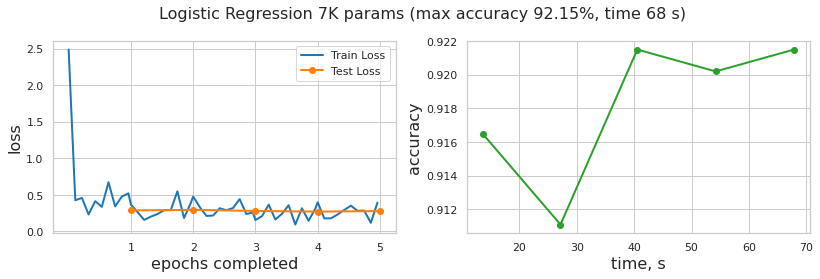

In [ ]:
logreg = LogReg().to(device)

logreg_train = train_test_plot(
    network=logreg,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=optim.Adam(params=logreg.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='Logistic Regression 7K params', savefig=True,
    # filename='logreg'
    )

Дёшево и сердито!

#### 2 fc layers + sigmoid, 8K params

In [ ]:
class TwoLayerPerc(nn.Module):
  def __init__(self):
    super().__init__()

    # 7940 parameters
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 10),
        nn.Sigmoid(),
        nn.Linear(10, 10)
    )

  def forward(self, x):
    return self.layers(x)


Test set: Avg. loss: 2.3812, Accuracy: 1027/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.339502
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.874182
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.550154
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.389530
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.223369
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.033560
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.017251
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.925002
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.819095
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.729157

Test set: Avg. loss: 0.7236, Accuracy: 8781/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.806119
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.496362
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.742844
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.545830
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.556526
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.581773
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.481866
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.459

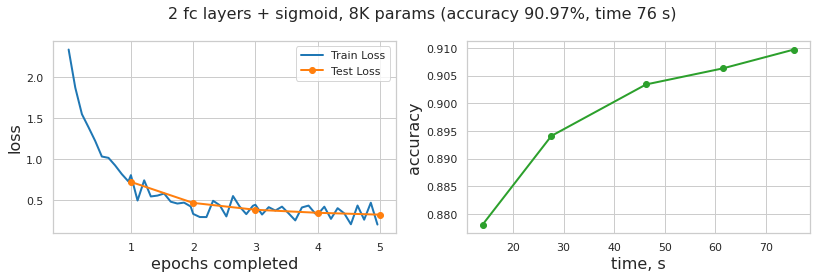

In [ ]:
twolayerperc = TwoLayerPerc().to(device)

twolayerperc_train = train_test_plot(
    network=twolayerperc,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=optimizer1(params=twolayerperc.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='2 fc layers + sigmoid, 8K params', savefig=True,
    filename='2fc8k'
    )

Учится медлненнее логрега

#### 2 fc layers + sigmoid, 55K params

In [ ]:
class TwoLayerPerc2(nn.Module):
  def __init__(self):
    super().__init__()

    # 55580 parameters
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(787, 70),
        nn.Sigmoid(),
        nn.Linear(70, 10),
    )

  def forward(self, x):
    return self.layers(x)


Test set: Avg. loss: 2.4089, Accuracy: 982/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.484372
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.841010
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.473665
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.507632
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.536780
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.217370
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.277480
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.220249
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.254312
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.218276

Test set: Avg. loss: 0.2384, Accuracy: 9319/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.214045
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.265177
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.240784
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.206459
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.263950
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.350472
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.128376
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.2006

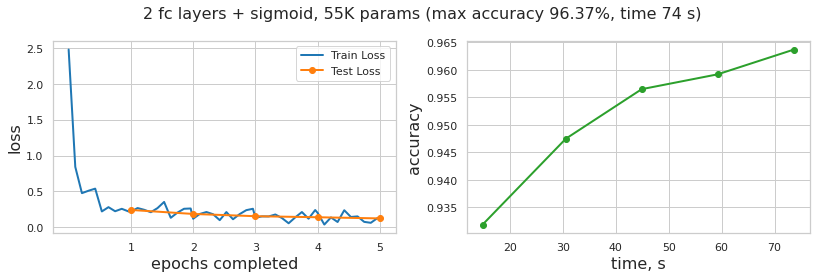

In [ ]:
twolayerperc2 = TwoLayerPerc2().to(device)

twolayerperc2_train = train_test_plot(
    network=twolayerperc2,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=optimizer1(params=twolayerperc2.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='2 fc layers + sigmoid, 55K params',
    filename='2fc55k'
    )

Учится чуть быстрее, но все еще медленнее логрега

#### 2 fc layers + ReLU, 55K params

In [ ]:
class TwoLayerPercReLU(nn.Module):
  def __init__(self):
    super().__init__()

    # 55580 parameters
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(787, 70),
        nn.ReLU(),
        nn.Linear(70, 10),
    )

  def forward(self, x):
    return self.layers(x)


Test set: Avg. loss: 2.3372, Accuracy: 867/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.345826
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.238400
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.338743
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.220749
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.168502
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.187913
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.285877
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.077866
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.113966
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.215285

Test set: Avg. loss: 0.1669, Accuracy: 9495/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.188816
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.108617
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.086694
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.179784
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.094488
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.142124
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.059192
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.16395

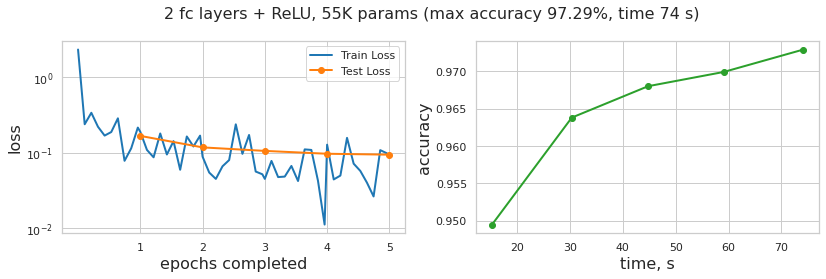

In [ ]:
twolayerpercrelu = TwoLayerPercReLU().to(device)

twolayerpercrelu_train = train_test_plot(
    network=twolayerpercrelu,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=optimizer1(params=twolayerpercrelu.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='2 fc layers + ReLU, 55K params',
    filename='2fcrelu55k',
    loss_scale='log'
    )

Не переобучается даже после 10 эпох, но рост очень медленный (стоит поменять оптимизатор?)

#### 2 fc layers + ReLU + batch-norm, 55K params

Идея добавить батч норм тупая, но мне просто интересно улучшится ли

In [ ]:
class TwoLayerPercReLUBatch(nn.Module):
  def __init__(self):
    super().__init__()

    # 55650 parameters
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 70),
        nn.BatchNorm1d(70),
        nn.ReLU(),
        nn.Linear(70,10)
    )

  def forward(self, x):
    return self.layers(x)


Test set: Avg. loss: 2.3465, Accuracy: 829/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.372613
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.540551
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.267760
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.200880
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.418008
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.166670
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.100136
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.125254
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.221771
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.257626

Test set: Avg. loss: 0.1683, Accuracy: 9515/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.232039
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.168120
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.192986
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.317898
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.370513
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.176503
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.076484
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.13019

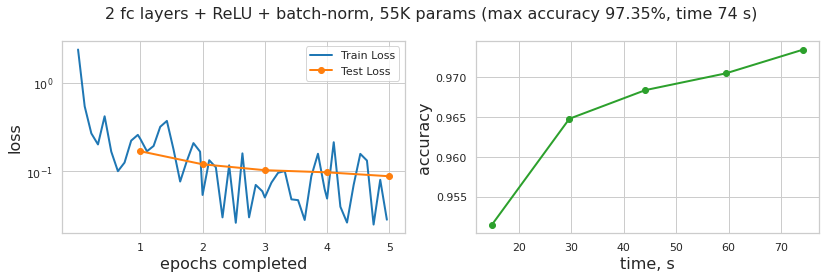

In [ ]:
twolayerpercrelubatch = TwoLayerPercReLUBatch().to(device)

twolayerpercrelubatch_train = train_test_plot(
    network=twolayerpercrelubatch,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=optimizer1(params=twolayerpercrelubatch.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='2 fc layers + ReLU + batch-norm, 55K params',
    filename='2fcnorm55k',
    loss_scale='log'
    )

#### 3 fc layers, 51K params

In [ ]:
class ThreeLayerPerc(nn.Module):
  def __init__(self):
    super().__init__()

    # 51240 parameters
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 60),
        nn.ReLU(),
        nn.Linear(60, 60),
        nn.ReLU(),
        nn.Linear(60, 10)
    )

  def forward(self, x):
    return self.layers(x)


Test set: Avg. loss: 2.3128, Accuracy: 1531/10000 (15%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292082
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.437679
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.186364
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.419157
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.238544
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.287076
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.252080
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.213477
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.143417
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.190338

Test set: Avg. loss: 0.1584, Accuracy: 9533/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.197373
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.161582
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.131062
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.055013
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.085557
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.219778
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.126949
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.090

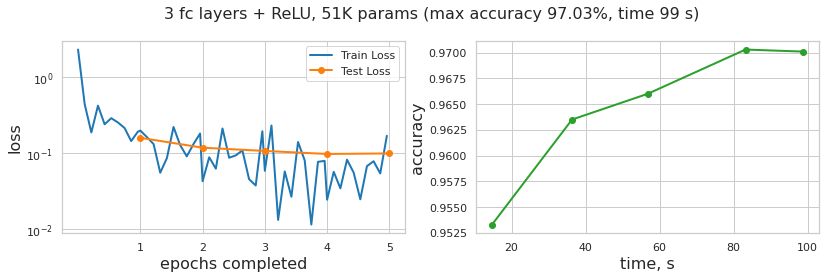

In [ ]:
threelayerperc = ThreeLayerPerc().to(device)

threelayerperc_train = train_test_plot(
    network=threelayerperc,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=optimizer1(params=threelayerperc.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='3 fc layers + ReLU, 51K params',
    filename='3fc51k',
    loss_scale='log'
    )

#### 3 fc layers + batch-norm after 1, 51K params

In [ ]:
class ThreeLayerPercBatch(nn.Module):
  def __init__(self):
    super().__init__()

    # 51240 parameters
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 60),
        nn.BatchNorm1d(60),
        nn.ReLU(),
        nn.Linear(60, 60),
        nn.ReLU(),
        nn.Linear(60, 10)
    )

  def forward(self, x):
    return self.layers(x)


Test set: Avg. loss: 2.2932, Accuracy: 1281/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.284023
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.417232
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.318723
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.218916
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110334
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.330749
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.159556
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.157902
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.168545
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.146723

Test set: Avg. loss: 0.1391, Accuracy: 9577/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.132537
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.269580
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.138445
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.145591
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.076843
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.062144
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.157188
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.104

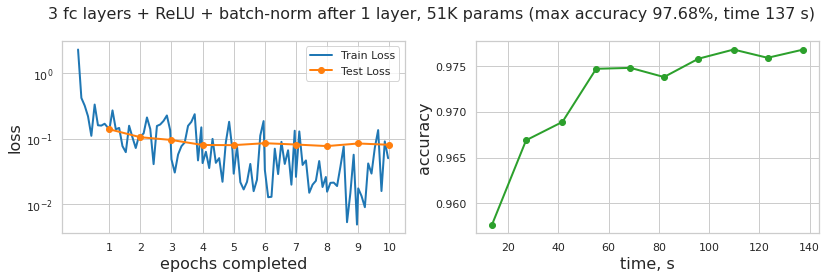

In [ ]:
threelayerpercbatch = ThreeLayerPercBatch().to(device)

threelayerpercbatch_train = train_test_plot(
    network=threelayerpercbatch,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=optim.Adam(params=threelayerpercbatch.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='3 fc layers + ReLU + batch-norm after 1 layer, 51K params',
    filename='3fcnorm51k',
    loss_scale='log'
    )

#### 3 fc layers + batch-norm after 2, 51K params

In [ ]:
class ThreeLayerPercBatch2(nn.Module):
  def __init__(self):
    super().__init__()

    # 51240 parameters
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 60),
        nn.ReLU(),
        nn.Linear(60, 60),
        nn.BatchNorm1d(60),
        nn.ReLU(),
        nn.Linear(60, 10)
    )

  def forward(self, x):
    return self.layers(x)


Test set: Avg. loss: 2.3165, Accuracy: 1107/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.386979
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.478141
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.297086
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.192712
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.204473
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.272955
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.110607
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.309415
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.237260
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.186985

Test set: Avg. loss: 0.1296, Accuracy: 9596/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.227948
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.074622
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.158282
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.194805
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.310552
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.190245
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.028682
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.151

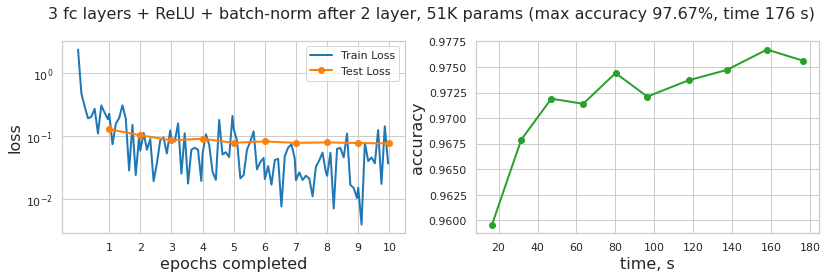

In [ ]:
threelayerpercbatch2 = ThreeLayerPercBatch2().to(device)

threelayerpercbatch2_train = train_test_plot(
    network=threelayerpercbatch2,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=optimizer1(params=threelayerpercbatch2.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='3 fc layers + ReLU + batch-norm after 2 layer, 51K params',
    filename='3fcnorm51k_2',
    loss_scale='log'
    )

#### 3 fc layers + 2 batch-norm

In [ ]:
class ThreeLayerPercBatch3(nn.Module):
  def __init__(self):
    super().__init__()

    # 51K parameters
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 60),
        nn.BatchNorm1d(60),
        nn.ReLU(),
        nn.Linear(60, 60),
        nn.BatchNorm1d(60),
        nn.ReLU(),
        nn.Linear(60, 10)
    )

  def forward(self, x):
    return self.layers(x)


Test set: Avg. loss: 2.3107, Accuracy: 1150/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298881
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.463622
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.303177
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.335111
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.264766
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.188317
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.129031
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.051692
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.053296
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.166405

Test set: Avg. loss: 0.1160, Accuracy: 9662/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.127808
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.255917
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.260860
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.061294
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.148496
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.287017
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.139648
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.160

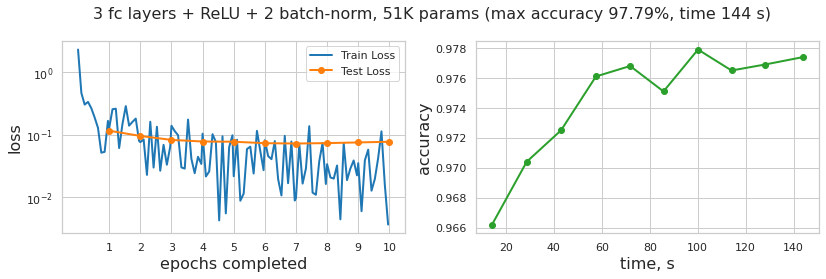

In [ ]:
threelayerpercbatch3 = ThreeLayerPercBatch3().to(device)

threelayerpercbatch3_train = train_test_plot(
    network=threelayerpercbatch3,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=optim.Adam(params=threelayerpercbatch3.parameters()),
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='3 fc layers + ReLU + 2 batch-norm, 51K params',
    filename='3fcnorm51k_3',
    loss_scale='log'
    )

### With Schedulers

#### ExponentialLR

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.2976, Accuracy: 1127/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.416768
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.522972
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.190178
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.421396
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.361866
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.261036
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.125178
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.096947
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.254484
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.139502

Test set: Avg. loss: 0.1216, Accuracy: 9638/10000 (96%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.162044
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.194267
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.241446
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.117944
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.130444
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.213

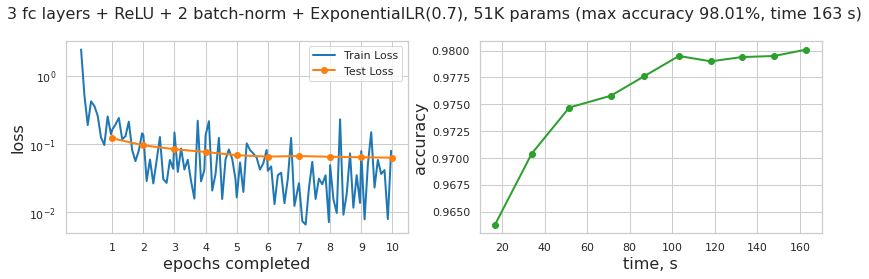

In [ ]:
my_bext_exp = ThreeLayerPercBatch3().to(device)

wrapped_opt = optim.Adam(params=my_bext_exp.parameters())
sceduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

threelayerpercbatch2_sc_train = train_test_plot(
    network=my_bext_exp,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='3 fc layers + ReLU + 2 batch-norm + ExponentialLR(0.7), 51K params',
    filename='3fcnorm51k_3_exp',
    scheduler=sceduler,
    loss_scale='log'
    )

#### PolynomialLR

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3020, Accuracy: 1411/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.374660
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.572550
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.253251
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.216040
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.286061
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.256875
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.210054
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.138530
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.118875
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.043084

Test set: Avg. loss: 0.1221, Accuracy: 9631/10000 (96%)

Adjusting learning rate of group 0 to 6.4000e-04.
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.068797
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.020634
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.095144
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.057001
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.071863
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.070

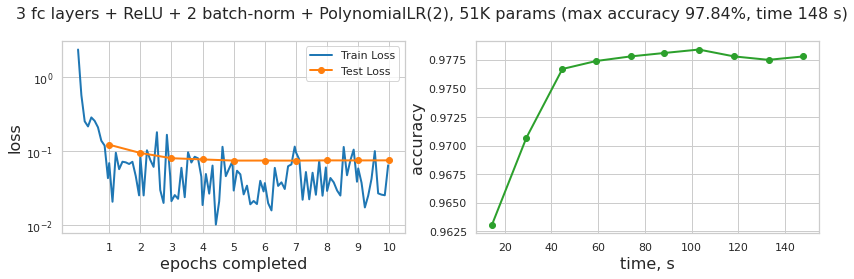

In [ ]:
my_best_poly = ThreeLayerPercBatch3().to(device)

wrapped_opt = optim.Adam(params=my_best_poly.parameters())
sceduler = optim.lr_scheduler.PolynomialLR(
    wrapped_opt, power=2, verbose=True)

my_best_poly_train = train_test_plot(
    network=my_best_poly,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_mnist_loader,
    test_loader=test_mnist_loader,
    title='3 fc layers + ReLU + 2 batch-norm + PolynomialLR(2), 51K params',
    filename='3fcnorm51k_3_poly',
    scheduler=sceduler,
    loss_scale='log'
    )

Ничего необычного

### Examine Images & Augmentation

In [ ]:
example_loader = iter(train_mnist_loader)

In [ ]:
example_data, example_targets = next(example_loader)
example_data.shape

torch.Size([64, 1, 28, 28])

In [ ]:
j = 0

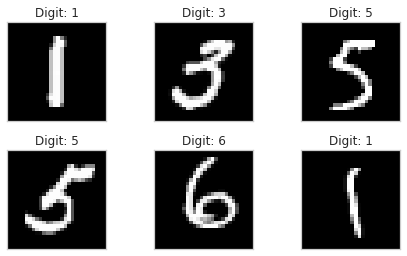

In [ ]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i+j][0], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(example_targets[i+j]))
  plt.xticks([])
  plt.yticks([])
j += 6

plt.savefig('mnist-demo.svg', bbox_inches='tight')

Различия цифр:
- толщина линии
- цинтрирование
- масштаб
- наклон
- просто различные стили написания цифр: 0, 2, 7

In [ ]:
mnist_aug_transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.GaussianBlur(kernel_size=5,sigma=0.3),
        transforms.RandomRotation(degrees=10),
        transforms.RandomCrop(size=28, padding=1, padding_mode='reflect'),    
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_mnist_aug = load_mnist(True, mnist_aug_transform)

train_mnist_aug_loader = torch.utils.data.DataLoader(
  dataset=train_mnist_aug, batch_size=64, shuffle=True)

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3113, Accuracy: 955/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299282
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.455001
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.365200
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.306750
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.256302
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.327247
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.392555
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.091318
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.093104
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.289900

Test set: Avg. loss: 0.1173, Accuracy: 9661/10000 (97%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.283415
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.089821
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.035050
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.175062
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.112717
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.1041

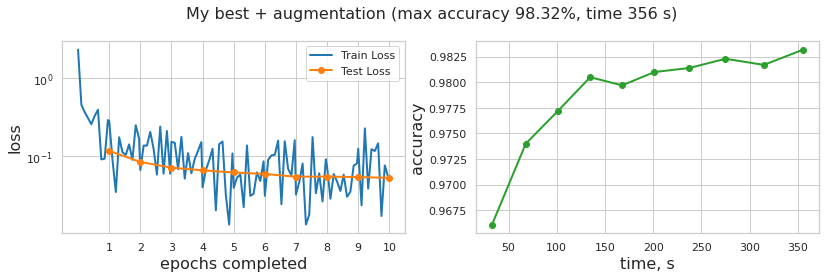

In [ ]:
my_best_aug = ThreeLayerPercBatch3().to(device)

wrapped_opt = optim.Adam(params=my_best_aug.parameters())
sceduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

my_best_aug_train = train_test_plot(
    network=my_best_aug,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_mnist_aug_loader,
    test_loader=test_mnist_loader,
    title='My best + augmentation',
    filename='3fcnorm51k_3_aug',
    scheduler=sceduler,
    loss_scale='log'
    )

#### Total

In [ ]:
plt.plot(logreg_train[-1], logreg_train[-2], marker='o',
         lw=2, color='lightcoral', label='LogReg (92.15%)')
plt.plot(threelayerpercbatch2_sc_train[-1], threelayerpercbatch2_sc_train[-2], marker='o',
         lw=2, color='mediumseagreen', label='3fc ()')
plt.plot(my_best_aug_train[-1], my_best_aug_train[-2], marker='o',
         lw=2, color='royalblue', label='3fc+aug')

plt.xlabel('time', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.title('Results compared with LogReg', fontsize=16)
plt.legend()

plt.savefig('comparison.svg', bbox_inches='tight')

plt.show()

NameError: ignored

## CIFAR10

### Prepare Data

In [ ]:
def load_cifar10(train, transform):
  return torchvision.datasets.CIFAR10(
    root='./data', train=train, transform=transform, download=True)

In [ ]:
ordinary_transform = transforms.Compose([transforms.ToTensor()])

train_cifar10_tmp = load_cifar10(True, ordinary_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
cifar10 = torch.empty((60000, 3, 32, 32))
for i, (img, target) in enumerate(train_cifar10_tmp):
  cifar10[i] = img

In [ ]:
cifar10.mean(), cifar10.std()

(tensor(0.3945), tensor(0.2896))

In [ ]:
my_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.3945,), (0.2896,))])

train_cifar10 = load_cifar10(True, my_transform)
test_cifar10 = load_cifar10(False, my_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size_train = 64
batch_size_test = 1000

train_cifar10_loader = torch.utils.data.DataLoader(
  dataset=train_cifar10, batch_size=batch_size_train, shuffle=True)

test_cifar10_loader = torch.utils.data.DataLoader(
  dataset=test_cifar10, batch_size=batch_size_test, shuffle=True)

### Deriving CNN

#### conv5 + 1 fc, 8K params

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    # 8K parameters
    # = 5*5*3+7840
    self.layers = nn.Sequential(
        nn.Conv2d(3, 1, kernel_size=5), # 32x32 -> 28x28
        nn.ReLU(),
        
        nn.Flatten(),
        
        nn.Linear(784, 10),
    )

  def forward(self, x):
    return self.layers(x)

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3253, Accuracy: 949/10000 (9%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.294413
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.179964
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.130419
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.053170
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.044387
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.998730
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.139016
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.100599

Test set: Avg. loss: 2.0352, Accuracy: 2942/10000 (29%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.878224
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.957431
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.931721
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.159834
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.937514
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.935668
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.989273
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.07269

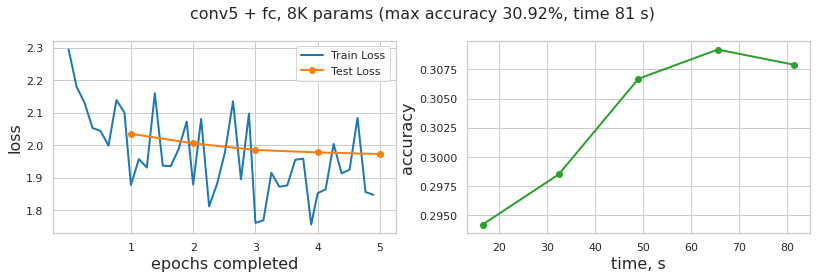

In [ ]:
convnet = ConvNet().to(device)

wrapped_opt = optim.Adam(params=convnet.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

convnet_train = train_test_plot(
    network=convnet,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='conv5 + fc, 8K params',
    scheduler=scheduler,
    )

#### conv5 + maxpool2 + 1 fc, 2K params

In [ ]:
class ConvNetMxpool(nn.Module):
  def __init__(self):
    super().__init__()

    # 2K parameters
    # = 5*5*3+1960
    self.layers = nn.Sequential(
        nn.Conv2d(3, 1, kernel_size=5), # 32x32 -> 28x28
        nn.MaxPool2d(kernel_size=2), # 28x28 -> 14x14
        nn.ReLU(),
        
        nn.Flatten(),
        
        nn.Linear(196, 10),
    )

  def forward(self, x):
    return self.layers(x)

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3152, Accuracy: 957/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.309353
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.276019
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.072422
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.043763
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.946686
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.116772
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.925230
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.011199

Test set: Avg. loss: 1.9879, Accuracy: 2999/10000 (30%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.845707
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.911577
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.838923
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.062561
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.795898
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.075726
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.998556
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.8815

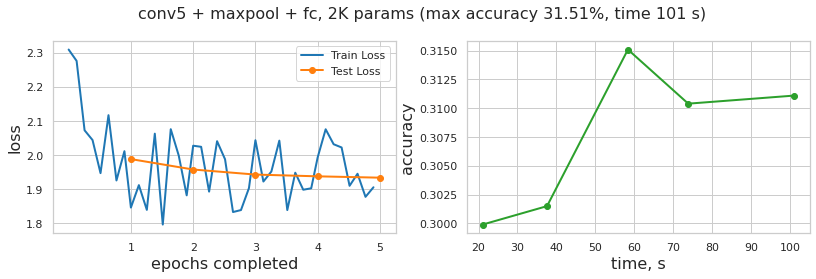

In [ ]:
convnetmxpool = ConvNetMxpool().to(device)

wrapped_opt = optim.Adam(params=convnetmxpool.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

convnetmxpool_train = train_test_plot(
    network=convnetmxpool,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='conv5 + maxpool + fc, 2K params',
    scheduler=scheduler
    )

#### conv5 + 2 fc + batch-norm, 47K params

In [ ]:
class ConvNet2fc(nn.Module):
  def __init__(self):
    super().__init__()

    # 47K parameters
    # = 5*5*3+784*60+120+120+60
    self.layers = nn.Sequential(
        nn.Conv2d(3, 1, kernel_size=5), # 32x32 -> 28x28
        nn.ReLU(),
        
        nn.Flatten(),
        
        nn.Linear(784, 60),
        nn.BatchNorm1d(60),
        nn.ReLU(),
        
        nn.Linear(60, 10)
    )

  def forward(self, x):
    return self.layers(x)

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3060, Accuracy: 1065/10000 (11%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.349188
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.924788
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.047700
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.860311
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.764364
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.815633
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.687274
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.727051

Test set: Avg. loss: 1.7837, Accuracy: 3589/10000 (36%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.689622
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.019508
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.026575
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.624741
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.764739
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.982745
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.563642
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.804

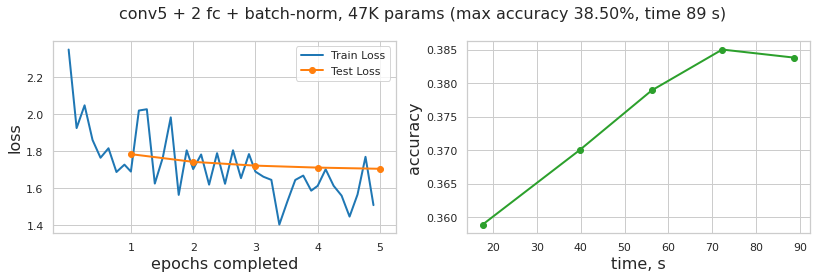

In [ ]:
convnet2fc = ConvNet2fc().to(device)

wrapped_opt = optim.Adam(params=convnet2fc.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

convnet2fc_train = train_test_plot(
    network=convnet2fc,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='conv5 + 2 fc + batch-norm, 47K params',
    scheduler=scheduler
    )

#### 2 conv5 + 2 fc + batch-norm, 21K params

In [ ]:
class Conv2Net2fc(nn.Module):
  def __init__(self):
    super().__init__()

    # 21K parameters =
    # 5*5*3*6+5*5*6*12+300*60+120+600
    self.layers = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5),     # 3x32x32 -> 6x28x28
        nn.MaxPool2d(kernel_size=2),        # 6x28x28 -> 6x14x14
        nn.ReLU(),
        
        nn.Conv2d(6, 12, kernel_size=5),    # 6x14x14 -> 12x10x10
        nn.MaxPool2d(kernel_size=2),        # 12x10x10 -> 12x5x5
        nn.ReLU(),
        
        nn.Flatten(),                       # 12x5x5 -> 300
        
        nn.Linear(300, 60), 
        nn.BatchNorm1d(60),
        nn.ReLU(),
        
        nn.Linear(60, 10)
    )

  def forward(self, x):
    return self.layers(x)

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3063, Accuracy: 798/10000 (8%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.319191
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.729085
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.348587
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.410303
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.480022
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.465510
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.552505
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.362766

Test set: Avg. loss: 1.3142, Accuracy: 5327/10000 (53%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.255031
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.292530
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.123024
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.244918
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.060570
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.122103
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.848454
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.97670

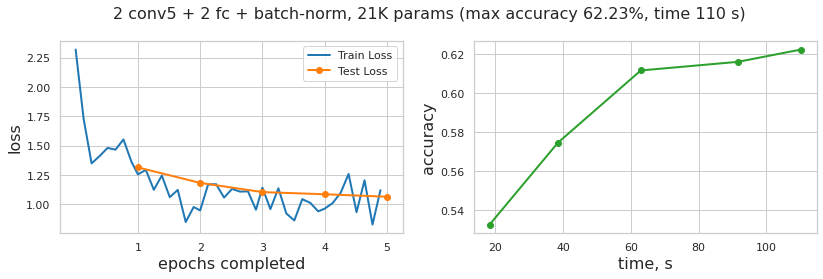

In [ ]:
conv2net2fc = Conv2Net2fc().to(device)

wrapped_opt = optim.Adam(params=conv2net2fc.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

conv2net2fc_train = train_test_plot(
    network=conv2net2fc,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='2 conv5 + 2 fc + batch-norm, 21K params',
    scheduler=scheduler
    )

**как достигается разнообразие сверток при увеличении каналов?**

#### 2 conv5 + 2 fc + batch-norm, 36K params

In [ ]:
class Conv2Net2fc_2(nn.Module):
  def __init__(self):
    super().__init__()

    # 36K parameters =
    # 5*5*3*10+5*5*10*20+500*60+120+600
    self.layers = nn.Sequential(
        nn.Conv2d(3, 10, kernel_size=5),     # 3x32x32 -> 10x28x28
        nn.MaxPool2d(kernel_size=2),        # 10x28x28 -> 10x14x14
        nn.ReLU(),
        
        nn.Conv2d(10, 20, kernel_size=5),    # 10x14x14 -> 20x10x10
        nn.MaxPool2d(kernel_size=2),        # 20x10x10 -> 20x5x5
        nn.ReLU(),
        nn.Flatten(),                       # 20x5x5 -> 500
        
        nn.Linear(500, 60), 
        nn.BatchNorm1d(60),
        nn.ReLU(),
        
        nn.Linear(60, 10)
    )

  def forward(self, x):
    return self.layers(x)

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3106, Accuracy: 1045/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.381189
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.804658
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.428119
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.376060
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.261781
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.303555
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.141559
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.299019

Test set: Avg. loss: 1.2557, Accuracy: 5573/10000 (56%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.312029
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.004345
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.871844
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.362246
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.240257
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.108062
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.128307
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.089

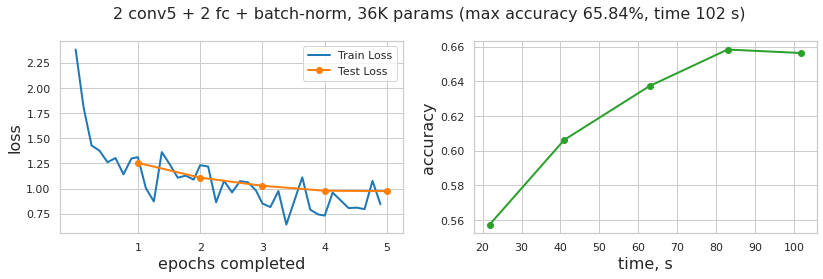

In [ ]:
conv2net2fc_2 = Conv2Net2fc_2().to(device)

wrapped_opt = optim.Adam(params=conv2net2fc_2.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

conv2net2fc_2_train = train_test_plot(
    network=conv2net2fc_2,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='2 conv5 + 2 fc + batch-norm, 36K params',
    scheduler=scheduler
    )

#### 3 conv + 2 fc + batch-norm, 41K params

**всегда ли нужно ставить функцию активации после свёрточного слоя?**


In [ ]:
class Conv3Net2fc(nn.Module):
  def __init__(self):
    super().__init__()

    # 41K parameters =
    # 5*5*3*30+3*3*30*30+3*3*30*60+240*60+120+600
    self.layers = nn.Sequential(
        nn.Conv2d(3, 30, kernel_size=5),     # 3x32x32 -> 30x28x28
        nn.MaxPool2d(kernel_size=2),        # 30x28x28 -> 30x14x14
        nn.ReLU(),
        
        nn.Conv2d(30, 30, kernel_size=3),    # 30x14x14 -> 30x12x12
        nn.MaxPool2d(kernel_size=2),        # 30x12x12 -> 30x6x6
        nn.ReLU(),
        
        nn.Conv2d(30, 60, kernel_size=3),    # 30x6x6 -> 60x4x4
        nn.MaxPool2d(kernel_size=2),        # 60x4x4 -> 60x2x2
        nn.ReLU(),
        
        nn.Flatten(),                       # 60x2x2 -> 240
        
        nn.Linear(240, 60), 
        nn.BatchNorm1d(60),
        nn.ReLU(),
        
        nn.Linear(60, 10)
    )

  def forward(self, x):
    return self.layers(x)

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3049, Accuracy: 1184/10000 (12%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.332974
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.626130
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.397635
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.245752
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.194204
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.263962
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.330185
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.064987

Test set: Avg. loss: 1.1630, Accuracy: 5785/10000 (58%)

Adjusting learning rate of group 0 to 5.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.116961
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.819953
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.311723
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.940627
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.998230
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.001274
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.171325
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.839

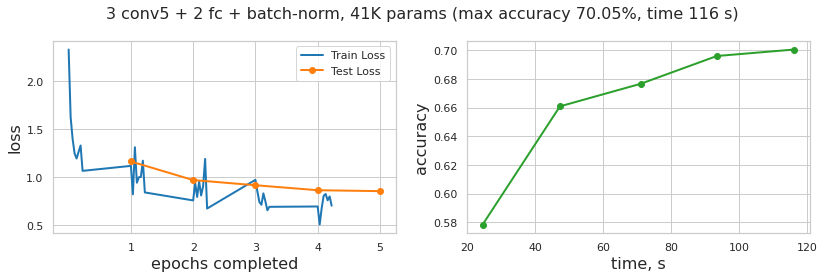

In [ ]:
conv3net2fc = Conv3Net2fc().to(device)

wrapped_opt = optim.Adam(params=conv3net2fc.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.5, verbose=True)

conv3net2fc_train = train_test_plot(
    network=conv3net2fc,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='3 conv5 + 2 fc + batch-norm, 41K params',
    scheduler=scheduler
    )

### VGG Inspired

#### VGG Inspired, 180K params

**стоит попробовать fine-tuning, как в VGG?**

In [ ]:
class VGG1(nn.Module):
  def __init__(self):
    super().__init__()

    # 180K parameters =
    # 3*3*3*15+3*3*15*30+3*3*30*45+3*3*45*60+3*3*60*75+3*3*75*90+36000+200+1000
    self.layers = nn.Sequential(
        nn.Conv2d(3, 15, kernel_size=3, padding=1),     # 15x32x32
        nn.ReLU(),
        
        nn.Conv2d(15, 30, kernel_size=3, padding=1),    # 30x32x32
        nn.MaxPool2d(kernel_size=2),                    # 30x16x16    
        nn.ReLU(),
        
        nn.Conv2d(30, 45, kernel_size=3, padding=1),    # 45x16x16
        nn.ReLU(),
        
        nn.Conv2d(45, 60, kernel_size=3, padding=1),    # 60x16x16
        nn.MaxPool2d(kernel_size=2),                    # 60x8x8
        nn.ReLU(),
        
        nn.Conv2d(60, 75, kernel_size=3),               # 75x6x6
        nn.ReLU(),
        
        nn.Conv2d(75, 90, kernel_size=3),               # 90x4x4
        nn.MaxPool2d(kernel_size=2),                    # 90x2x2
        nn.ReLU(),
        
        nn.Flatten(),                                   # 360
        
        nn.Linear(360, 100), 
        nn.BatchNorm1d(100),
        nn.ReLU(),
        
        nn.Linear(100, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(VGG1())

179780

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3046, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.298234
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.467398
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.387831
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.229095
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.175650
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.150121
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.986853
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.227502

Test set: Avg. loss: 1.0580, Accuracy: 6222/10000 (62%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.804466
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.776476
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.708524
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.887062
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.727960
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.203496
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.862718
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.564

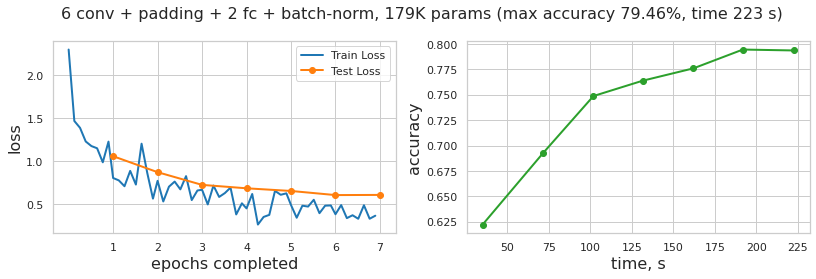

In [ ]:
vgg1 = VGG1().to(device)

wrapped_opt = optim.Adam(params=vgg1.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

vgg1_train = train_test_plot(
    network=vgg1,
    n_epochs=7,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='VGG 6 conv + 2 fc, 179K params',
    scheduler=scheduler
    )

#### VGG Inspired, 542K params

In [ ]:
class VGG2(nn.Module):
  def __init__(self):
    super().__init__()

    # 543K parameters =
    # 3*3*3*15+3*3*15*30+3*3*30*60+3*3*60*120+3*3*120*120+3*3*120*240+960*70+140+700
    self.layers = nn.Sequential(
        nn.Conv2d(3, 15, kernel_size=3, padding=1),     # 15x32x32
        nn.ReLU(),
        
        nn.Conv2d(15, 30, kernel_size=3, padding=1),    # 30x32x32
        nn.MaxPool2d(kernel_size=2),                    # 30x16x16    
        nn.ReLU(),
        
        nn.Conv2d(30, 60, kernel_size=3, padding=1),    # 60x16x16
        nn.ReLU(),
        
        nn.Conv2d(60, 120, kernel_size=3, padding=1),   # 120x16x16
        nn.MaxPool2d(kernel_size=2),                    # 120x8x8
        nn.ReLU(),
        
        nn.Conv2d(120, 120, kernel_size=3),             # 120x6x6
        nn.ReLU(),
        
        nn.Conv2d(120, 240, kernel_size=3),             # 240x4x4
        nn.MaxPool2d(kernel_size=2),                    # 240x2x2
        nn.ReLU(),
        
        nn.Flatten(),                                   # 960
        
        nn.Linear(960, 70), 
        nn.BatchNorm1d(70),
        nn.ReLU(),
        
        nn.Linear(70, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(VGG2())

542960

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3046, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.330759
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.646620
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.432275
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.233184
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.272703
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.907266
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.920872
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.071016

Test set: Avg. loss: 1.0306, Accuracy: 6358/10000 (64%)

Adjusting learning rate of group 0 to 5.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.056574
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.814358
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.853924
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.683716
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.678757
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.742690
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.746989
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.814

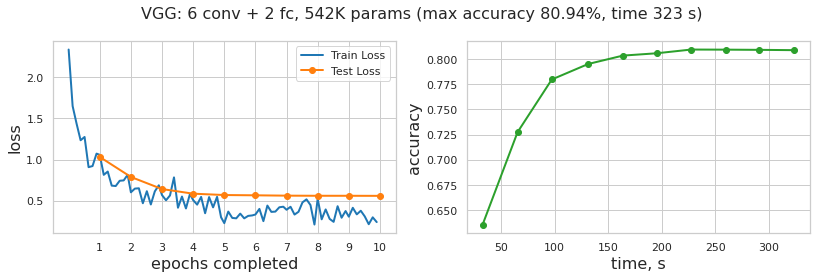

In [ ]:
vgg2 = VGG2().to(device)

wrapped_opt = optim.Adam(params=vgg2.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.5, verbose=True)

vgg2_train = train_test_plot(
    network=vgg2,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='VGG: 6 conv + 2 fc, 542K params',
    scheduler=scheduler
    )

Шалость не удалась: число параметров выросло в 4 раза, а точность увеличилась на один процент.

Есть переобучение. Попробовать drop out?

#### VGG Inspired + dropout, 173K params

In [ ]:
class VGGDrop(nn.Module):
  def __init__(self):
    super().__init__()

    # 173K parameters
    self.layers = nn.Sequential(
        nn.Conv2d(3, 15, kernel_size=3, padding=1),     # 15x32x32
        nn.ReLU(),
        
        nn.Conv2d(15, 30, kernel_size=3, padding=1),    # 30x32x32
        nn.MaxPool2d(kernel_size=2),                    # 30x16x16    
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Conv2d(30, 45, kernel_size=3, padding=1),    # 45x16x16
        nn.ReLU(),
        
        nn.Conv2d(45, 60, kernel_size=3, padding=1),    # 60x16x16
        nn.MaxPool2d(kernel_size=2),                    # 60x8x8
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Conv2d(60, 75, kernel_size=3),               # 75x6x6
        nn.ReLU(),
        
        nn.Conv2d(75, 90, kernel_size=3),               # 90x4x4
        nn.MaxPool2d(kernel_size=2),                    # 90x2x2
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Flatten(),                                   # 360
        
        nn.Linear(360, 70), 
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Linear(70, 70), 
        
        nn.BatchNorm1d(70),
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Linear(70, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(VGGDrop())

173560

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3058, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.442185
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.958279
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.035263
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.823667
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.562031
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.428665
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.509571
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.484769

Test set: Avg. loss: 1.2464, Accuracy: 5471/10000 (55%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.266979
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.309794
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.226660
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.148826
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.348363
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.045189
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.126637
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.201

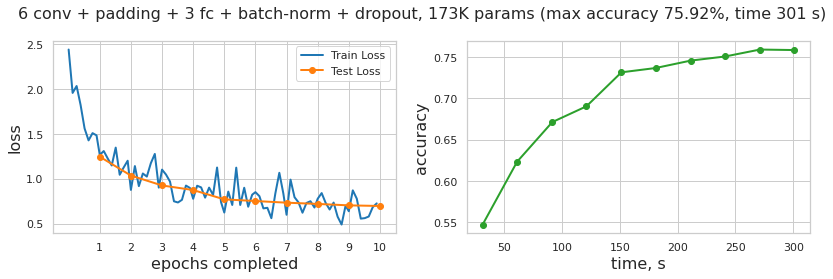

In [ ]:
vggdrop = VGGDrop().to(device)

wrapped_opt = optim.Adam(params=vggdrop.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)


vggdrop_train = train_test_plot(
    network=vggdrop,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='6 conv + padding + 3 fc + batch-norm + dropout, 173K params',
    scheduler=scheduler
    )

#### Fewer dropouts, 169K

In [ ]:
class VGGDrop_2(nn.Module):
  def __init__(self):
    super().__init__()

    # 169K parameters
    self.layers = nn.Sequential(
        nn.Conv2d(3, 15, kernel_size=3, padding=1),     # 15x32x32
        nn.BatchNorm2d(15),
        nn.ReLU(),

        nn.Conv2d(15, 30, kernel_size=3, padding=1),    # 30x32x32
        nn.BatchNorm2d(30),
        nn.MaxPool2d(kernel_size=2),                    # 30x16x16    
        nn.ReLU(),

        nn.Conv2d(30, 45, kernel_size=3, padding=1),    # 45x16x16
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(45),
        nn.ReLU(),

        nn.Conv2d(45, 60, kernel_size=3, padding=1),    # 60x16x16
        nn.BatchNorm2d(60),
        nn.MaxPool2d(kernel_size=2),                    # 60x8x8
        nn.ReLU(),

        nn.Conv2d(60, 75, kernel_size=3),               # 75x6x6
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(75),
        nn.ReLU(),

        nn.Conv2d(75, 90, kernel_size=3),               # 90x4x4
        nn.BatchNorm2d(90),
        nn.MaxPool2d(kernel_size=2),                    # 90x2x2
        nn.ReLU(),
        
        nn.Flatten(),                                   # 360

        nn.Linear(360, 70), 
        nn.Dropout(p=0.2),
        nn.BatchNorm1d(70),
        nn.ReLU(),

        nn.Linear(70, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(VGGDrop_2())

169220

In [ ]:
vggdrop_2 = VGGDrop_2().to(device)

wrapped_opt = optim.Adam(params=vggdrop_2.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

vggdrop_2_train = train_test_plot(
    network=vggdrop_2,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='VGG: 6 conv + 2 fc + dropout, 169K params',
    scheduler=scheduler
    )

NameError: ignored

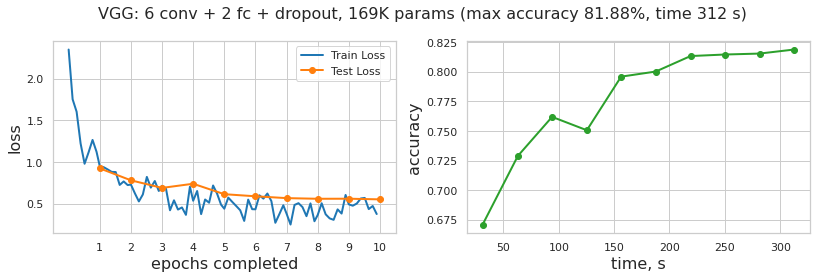

In [ ]:
plot(10, 'linear', True, 'VGG: 6 conv + 2 fc + dropout, 169K params', *vggdrop_2_train)

### Inception Inspired

#### Inception v1 block with dim reduction

Взято отсюда: [InceptionNet in Pytorch](https://jaketae.github.io/study/pytorch-inception/).

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(ConvBlock, self).__init__()
      
    self.layers = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, **kwargs),
      nn.BatchNorm2d(out_channels),
      nn.ReLU())
        
  def forward(self, x):
    return self.layers(x)

In [ ]:
class InceptionBlock(nn.Module):
  def __init__(
    self, 
    in_channels, 
    out_1x1,
    red_3x3,
    out_3x3,
    red_5x5,
    out_5x5,
    out_pool,
  ):
    super(InceptionBlock, self).__init__()
    self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
    self.branch2 = nn.Sequential(
      ConvBlock(in_channels, red_3x3, kernel_size=1, padding=0),
      ConvBlock(red_3x3, out_3x3, kernel_size=3, padding=1),
    )
    self.branch3 = nn.Sequential(
      ConvBlock(in_channels, red_5x5, kernel_size=1),
      ConvBlock(red_5x5, out_5x5, kernel_size=5, padding=2),
    )
    self.branch4 = nn.Sequential(
      nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
      ConvBlock(in_channels, out_pool, kernel_size=1),
    )

  def forward(self, x):
    branches = (self.branch1, self.branch2, self.branch3, self.branch4)
    return torch.cat([branch(x) for branch in branches], 1)

#### VGG + 1 inception block, 132K params

In [ ]:
class VGGInceptionV1(nn.Module):
  def __init__(self):
    super().__init__()

    # 132K parameters
    self.layers = nn.Sequential(
        ConvBlock(3, 15, kernel_size=3, padding=1),     # 15x32x32
        
        ConvBlock(15, 30, kernel_size=3, padding=1),    # 30x32x32
        nn.MaxPool2d(kernel_size=2),                    # 30x16x16
        
        nn.Dropout(p=0.2),

        InceptionBlock(
            in_channels=30,
            out_1x1=10,
            red_3x3=15,
            out_3x3=20,
            red_5x5=5,
            out_5x5=10,
            out_pool=5
        ),                                              # 45x16x16
        
        nn.Dropout(p=0.2),
        nn.MaxPool2d(kernel_size=2),                     # 45x8x8
        
        ConvBlock(45, 75, kernel_size=3),               # 75x6x6
        
        ConvBlock(75, 90, kernel_size=3),               # 90x4x4
        nn.MaxPool2d(kernel_size=2),                    # 90x2x2
        
        nn.Dropout(p=0.2),
        
        nn.Flatten(),                                   # 360
        
        nn.Linear(360, 70), 
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Linear(70, 70), 
        nn.BatchNorm1d(70),
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Linear(70, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
model = VGGInceptionV1().to(device)
sum(p.numel() for p in model.parameters() if p.requires_grad)

132495

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3047, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.433027
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.861705
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.336083
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.429468
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.366357
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.176621
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.340789
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.914148

Test set: Avg. loss: 1.3880, Accuracy: 5063/10000 (51%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.250374
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.042971
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.809455
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.858160
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.184553
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.909079
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.960059
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.033

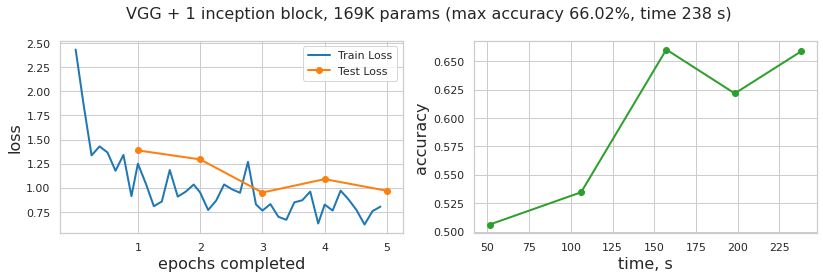

In [ ]:
vgginception = VGGInceptionV1().to(device)

wrapped_opt = optim.Adam(params=vgginception.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

vgginception_train = train_test_plot(
    network=vgginception,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='VGG + 1 inception block, 169K params',
    scheduler=scheduler,
    )

#### VGG + 2 inception blocks, 158K params

In [ ]:
class VGG2InceptionV1(nn.Module):
  def __init__(self):
    super().__init__()

    # 158K parameters
    self.layers = nn.Sequential(
        ConvBlock(3, 15, kernel_size=3, padding=1),     # 15x32x32
        
        ConvBlock(15, 30, kernel_size=3, padding=1),    # 30x32x32
        nn.MaxPool2d(kernel_size=2),                    # 30x16x16
        
        nn.Dropout(p=0.2),

        InceptionBlock(
            in_channels=30,
            out_1x1=10,
            red_3x3=15,
            out_3x3=20,
            red_5x5=5,
            out_5x5=10,
            out_pool=5
        ),                                              # 45x16x16

        InceptionBlock(
            in_channels=45,
            out_1x1=15,
            red_3x3=18,
            out_3x3=30,
            red_5x5=8,
            out_5x5=15,
            out_pool=8
        ),                                              # 68x16x16
        
        nn.Dropout(p=0.2),
        nn.MaxPool2d(kernel_size=2),                    # 68x8x8
        
        ConvBlock(68, 75, kernel_size=3),               # 75x6x6
        
        ConvBlock(75, 90, kernel_size=3),               # 90x4x4
        nn.MaxPool2d(kernel_size=2),                    # 90x2x2
        
        nn.Dropout(p=0.2),
        
        nn.Flatten(),                                   # 360
        
        nn.Linear(360, 70), 
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Linear(70, 70), 
        nn.BatchNorm1d(70),
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Linear(70, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(VGG2InceptionV1())

158367

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3057, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.391510
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.725751
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.748485
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.449555
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.323412
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.440225
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.060533
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.500363

Test set: Avg. loss: 1.1931, Accuracy: 5755/10000 (58%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.996960
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.094571
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.182907
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.398264
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.182771
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.157242
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.990555
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.898

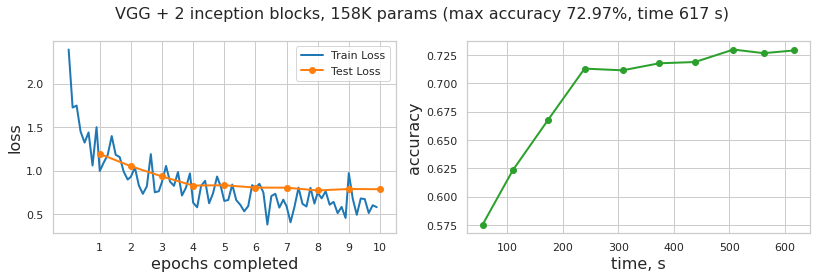

In [ ]:
vgg2inception = VGG2InceptionV1().to(device)

wrapped_opt = optim.Adam(params=vgg2inception.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

vgg2inception_train = train_test_plot(
    network=vgg2inception,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='VGG + 2 inception blocks, 158K params',
    scheduler=scheduler,
    )

#### 4 inception blocks, 148K params

In [ ]:
class Inception4(nn.Module):
  def __init__(self):
    super().__init__()

    # 148K parameters
    self.layers = nn.Sequential(
        ConvBlock(3, 15, kernel_size=3, padding=1),     # 15x32x32
        
        ConvBlock(15, 30, kernel_size=3, padding=1),    # 30x32x32
        nn.MaxPool2d(kernel_size=2),                    # 30x16x16
        
        nn.Dropout(p=0.2),

        InceptionBlock(in_channels=30, out_1x1=10,
                       red_3x3=15, out_3x3=20,
                       red_5x5=5, out_5x5=10,
                       out_pool=5),                     # 45x16x16

        nn.MaxPool2d(kernel_size=2),                    # 45x8x8

        InceptionBlock(in_channels=45, out_1x1=15,
                       red_3x3=18, out_3x3=30,
                       red_5x5=10, out_5x5=15,
                       out_pool=10),                    # 70x8x8

        nn.Dropout(p=0.2),

        InceptionBlock(in_channels=70, out_1x1=20,
                       red_3x3=25, out_3x3=50,
                       red_5x5=25, out_5x5=25,
                       out_pool=15),                     # 110x4x4
        
        nn.MaxPool2d(kernel_size=2),                     # 110x4x4
        
        InceptionBlock(in_channels=110, out_1x1=25,
                       red_3x3=25, out_3x3=70,
                       red_5x5=25, out_5x5=35,
                       out_pool=25),                     # 155x4x4
        
        nn.MaxPool2d(kernel_size=2),                    # 155x2x2
        nn.Dropout(p=0.2),
        nn.Flatten(),                                   # 620
        
        nn.Linear(620, 70), 
        nn.BatchNorm1d(70),
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Linear(70, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(Inception4())

147939

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3043, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.407569
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.468436
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.639301
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.218859
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.380301
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.378843
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.993039
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.068474

Test set: Avg. loss: 1.1222, Accuracy: 5980/10000 (60%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.024105
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.099048
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.123731
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.988651
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.839695
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.945470
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.320548
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.712

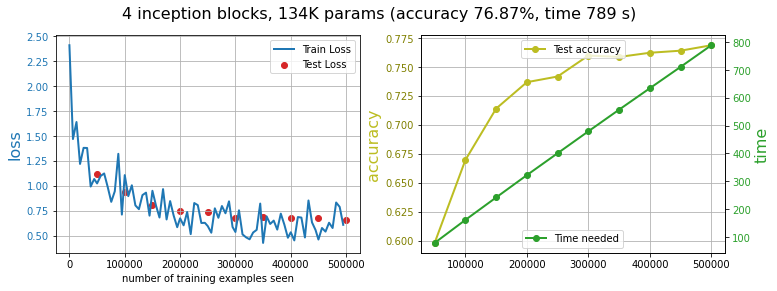

In [ ]:
inception4 = Inception4().to(device)

# wrapped_opt = optim.SGD(params=conv3net2fc.parameters(), lr=3e-4, momentum=0.9)
wrapped_opt = optim.Adam(params=inception4.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

inception4_train = train_test_plot(
    network=inception4,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='4 inception blocks, 134K params',
    scheduler=scheduler,
    )

#### 4 inception blocks, 514K params

In [ ]:
class Inception4_2(nn.Module):
  def __init__(self):
    super().__init__()

    # 514K parameters
    self.layers = nn.Sequential(
        ConvBlock(3, 30, kernel_size=3, padding=1),     # 30x32x32
        
        ConvBlock(30, 60, kernel_size=3, padding=1),    # 60x32x32
        nn.MaxPool2d(kernel_size=2),                    # 60x16x16
        
        nn.Dropout(p=0.2),

        InceptionBlock(in_channels=60, out_1x1=20,
                       red_3x3=30, out_3x3=40,
                       red_5x5=10, out_5x5=20,
                       out_pool=10),                     # 90x16x16

        nn.MaxPool2d(kernel_size=2),                    # 90x8x8

        InceptionBlock(in_channels=90, out_1x1=30,
                       red_3x3=35, out_3x3=60,
                       red_5x5=20, out_5x5=30,
                       out_pool=20),                    # 140x8x8

        nn.Dropout(p=0.2),

        InceptionBlock(in_channels=140, out_1x1=60,
                       red_3x3=50, out_3x3=100,
                       red_5x5=50, out_5x5=50,
                       out_pool=30),                     # 240x8x8
        
        nn.MaxPool2d(kernel_size=2),                     # 240x4x4
        
        InceptionBlock(in_channels=240, out_1x1=70,
                       red_3x3=50, out_3x3=140,
                       red_5x5=50, out_5x5=70,
                       out_pool=50),                     # 330x4x4
        
        nn.MaxPool2d(kernel_size=2),                    # 330x2x2
        nn.Dropout(p=0.2),
        nn.Flatten(),                                   # 1320
        
        nn.Linear(1320, 70), 
        nn.BatchNorm1d(70),
        nn.ReLU(),
        
        nn.Dropout(p=0.2),
        
        nn.Linear(70, 10)
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(Inception4_2())

514635

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3059, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.435545
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.660155
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.413053
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.158844
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.103162
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.013237
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.087818
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.912509

Test set: Avg. loss: 0.9728, Accuracy: 6589/10000 (66%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.867116
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.677781
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.796380
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.875718
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.780014
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.033993
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.637179
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.935

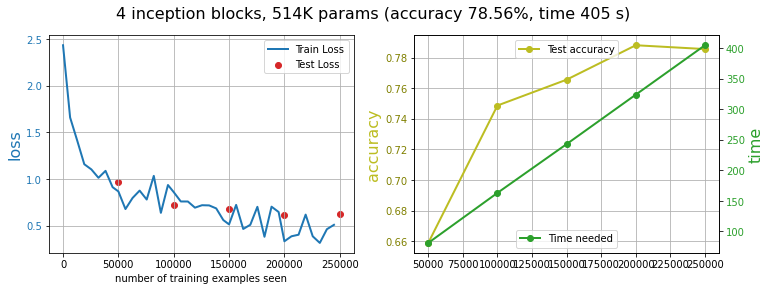

In [ ]:
inception4_2 = Inception4_2().to(device)

wrapped_opt = optim.Adam(params=inception4_2.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

inception4_2_train = train_test_plot(
    network=inception4_2,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_loader,
    test_loader=test_cifar10_loader,
    title='4 inception blocks, 514K params',
    scheduler=scheduler,
    # filename='my_best', savemodel=True
    )

### With Augmentation

In [ ]:
ordinary_transform = transforms.Compose([transforms.ToTensor()])
train_data = load_cifar10(True, ordinary_transform)

train_loader = torch.utils.data.DataLoader(
  dataset=train_data, batch_size=100, shuffle=True)

example_loader = iter(train_loader)

Files already downloaded and verified


In [ ]:
print('Training set')
print(f'Samples: {train_data.data.shape}')
print(f'Labels: {len(train_data.targets)}')

tags = list(train_data.class_to_idx.items())

print('\nClasses\n')
print(tabulate(
    tags, headers=['Name', 'Index'], 
    tablefmt='github'
))

Training set
Samples: (50000, 32, 32, 3)
Labels: 50000

Classes

| Name       |   Index |
|------------|---------|
| airplane   |       0 |
| automobile |       1 |
| bird       |       2 |
| cat        |       3 |
| deer       |       4 |
| dog        |       5 |
| frog       |       6 |
| horse      |       7 |
| ship       |       8 |
| truck      |       9 |


In [ ]:
example_data, example_targets = next(example_loader)
example_data.shape

torch.Size([100, 3, 32, 32])

In [ ]:
j = 0

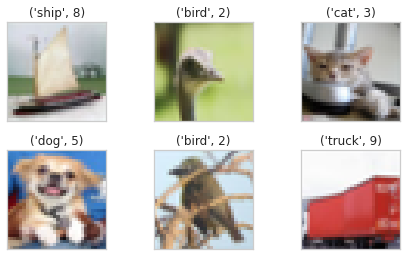

In [ ]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i+j].transpose(0,2).transpose(0,1), interpolation='none')
  plt.title(tags[example_targets[i+j]])
  plt.xticks([])
  plt.yticks([])
j += 6

plt.savefig('cifar10-demo.svg', bbox_inches='tight')

In [ ]:
aug_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.3945,), (0.2896,))])

train_cifar10_aug = load_cifar10(True, aug_transform)

Files already downloaded and verified


In [ ]:
batch_size_train = 16

train_cifar10_aug_loader = torch.utils.data.DataLoader(
  dataset=train_cifar10_aug, batch_size=batch_size_train, shuffle=True)

#### 4 inception blocks + 2 step augmentation, 514K

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3051, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.314944
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.920728
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.438159
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.460259
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.316367
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.275171
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.497509
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.463019

Test set: Avg. loss: 1.0075, Accuracy: 6410/10000 (64%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.277434
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.041153
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.162681
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.213509
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.427956
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.684181
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.169978
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.784

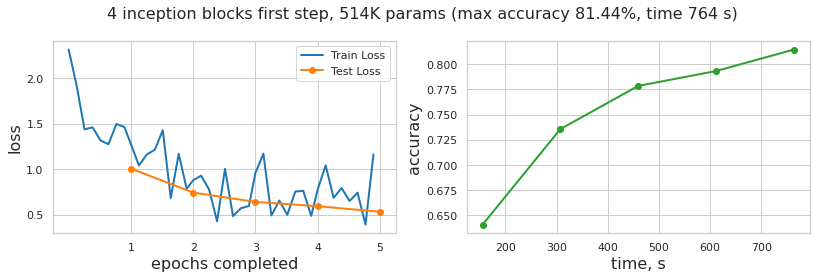

In [ ]:
inception4_2_aug = Inception4_2().to(device)

wrapped_opt = optim.Adam(params=inception4_2_aug.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

inception4_2_aug_train = train_test_plot(
    network=inception4_2_aug,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_aug_loader,
    test_loader=test_cifar10_loader,
    title='4 inception blocks first step, 514K params',
    scheduler=scheduler,
    log_interval=400
    )

Adjusting learning rate of group 0 to 4.0000e-04.

Test set: Avg. loss: 0.5331, Accuracy: 8144/10000 (81%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.682082
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.629793
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.704625
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.632065
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.180891
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.713507
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.070113
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.074955

Test set: Avg. loss: 0.5803, Accuracy: 7959/10000 (80%)

Adjusting learning rate of group 0 to 2.8000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.830539
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.226103
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.104593
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.620577
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.743880
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.521239
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.341093
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.611

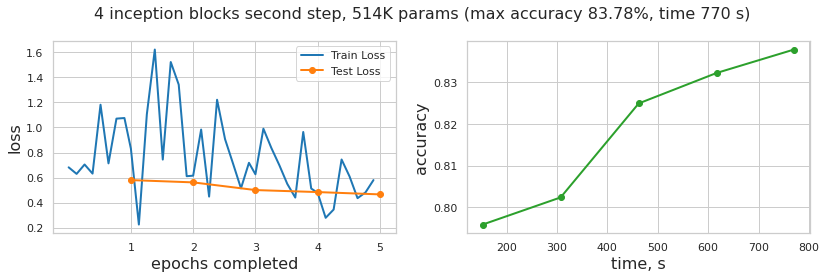

In [ ]:
wrapped_opt = optim.Adam(params=inception4_2_aug.parameters(), lr=4e-4)
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

inception4_2_aug_train_ = train_test_plot(
    network=inception4_2_aug,
    n_epochs=5,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_aug_loader,
    test_loader=test_cifar10_loader,
    title='4 inception blocks second step, 514K params',
    scheduler=scheduler,
    log_interval=400
    )

#### 4 inception blocks + 1 step augmentation, 514K

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3050, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.373070
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.856784
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.604981
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.656448
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.361781
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.031281
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.168715
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.401648

Test set: Avg. loss: 0.9785, Accuracy: 6533/10000 (65%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.536275
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.168377
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.085731
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.137335
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.412636
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.122020
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.969247
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.906

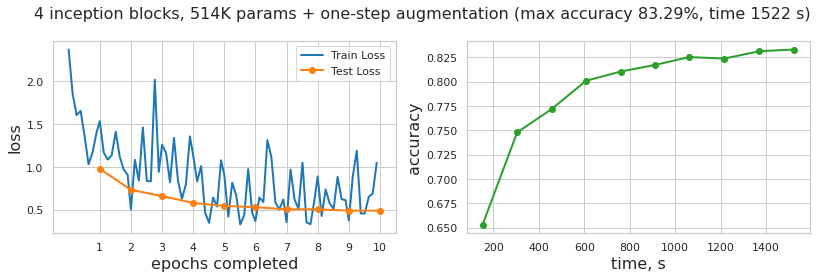

In [ ]:
inception4_2_aug2 = Inception4_2().to(device)

wrapped_opt = optim.Adam(params=inception4_2_aug2.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

inception4_2_aug2_train = train_test_plot(
    network=inception4_2_aug2,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_aug_loader,
    test_loader=test_cifar10_loader,
    title='4 inception blocks, 514K params + one-step augmentation',
    scheduler=scheduler,
    log_interval=400
    )

#### InceptionV1

In [ ]:
class InceptionV1(nn.Module):
  def __init__(self):
    super().__init__()

    # 1.2M parameters
    self.layers = nn.Sequential(
        ConvBlock(3, 30, kernel_size=3, padding=1),     # 30x32x32
        
        ConvBlock(30, 60, kernel_size=3, padding=1),    # 60x32x32
        nn.MaxPool2d(kernel_size=2),                    # 60x16x16
        
        nn.Dropout(p=0.2),

        InceptionBlock(in_channels=60, out_1x1=30,
                       red_3x3=30, out_3x3=50,
                       red_5x5=10, out_5x5=30,
                       out_pool=20),                    # 130x16x16

        InceptionBlock(in_channels=130, out_1x1=60,
                       red_3x3=40, out_3x3=100,
                       red_5x5=20, out_5x5=60,
                       out_pool=40),                    # 260x16x16

        nn.Dropout(p=0.2),

        InceptionBlock(in_channels=260, out_1x1=120,
                       red_3x3=50, out_3x3=200,
                       red_5x5=40, out_5x5=120,
                       out_pool=80),                     # 520x16x16
        
        nn.Dropout(p=0.2),
        
        InceptionBlock(in_channels=520, out_1x1=240,
                       red_3x3=50, out_3x3=400,
                       red_5x5=50, out_5x5=240,
                       out_pool=160),                     # 1040x16x16 
        
        nn.AdaptiveAvgPool2d((1,1)),   # 1040x1x1
        nn.Flatten(),
        nn.Linear(1040, 10), 
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(InceptionV1())

1173010

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3027, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.393275
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.118697
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.693450
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.646396
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.885768
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.667033
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.392329
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.113747

Test set: Avg. loss: 1.1059, Accuracy: 6047/10000 (60%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.327382
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.011701
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.275310
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.934796
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.793689
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.973335
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.133548
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.663

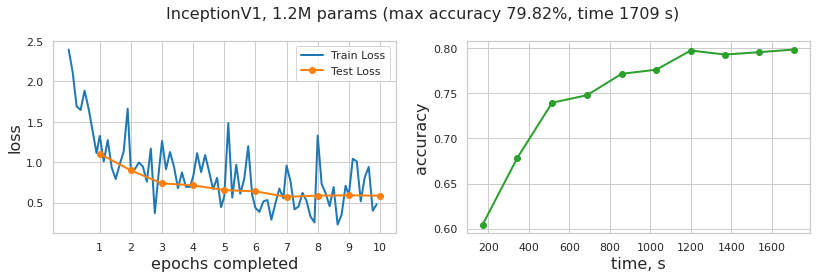

In [ ]:
inceptionv1 = InceptionV1().to(device)

wrapped_opt = optim.Adam(params=inceptionv1.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

inceptionv1_train = train_test_plot(
    network=inceptionv1,
    n_epochs=10,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_aug_loader,
    test_loader=test_cifar10_loader,
    title='InceptionV1, 1.2M params',
    scheduler=scheduler,
    log_interval=400
    )

### ResNet Inspired

#### 6.6M params

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, in_channels):
    super(ResBlock, self).__init__()

    self.layers = nn.Sequential(
      nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(in_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(in_channels))
  
  def forward(self, x):
    return F.relu(self.layers(x) + x)

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    
    self.layers = nn.Sequential(
        ConvBlock(3, 64, kernel_size=3, padding=1),
        ConvBlock(64, 128, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2),
        ResBlock(128),
        ConvBlock(128, 256, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2),
        ConvBlock(256, 512, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2),
        ResBlock(512),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(), 
        nn.Linear(512, 10))
      
  def forward(self, x):
    return self.layers(x)

In [ ]:
param_count(ResNet())

6575370

Adjusting learning rate of group 0 to 1.0000e-03.

Test set: Avg. loss: 2.3062, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.860003
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.307676
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.472293
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.291416
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.360137
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.877856
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.251097
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.937971

Test set: Avg. loss: 0.8521, Accuracy: 7016/10000 (70%)

Adjusting learning rate of group 0 to 7.0000e-04.
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.223447
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.602085
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.515573
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.998625
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.566472
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.617057
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.184022
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.971

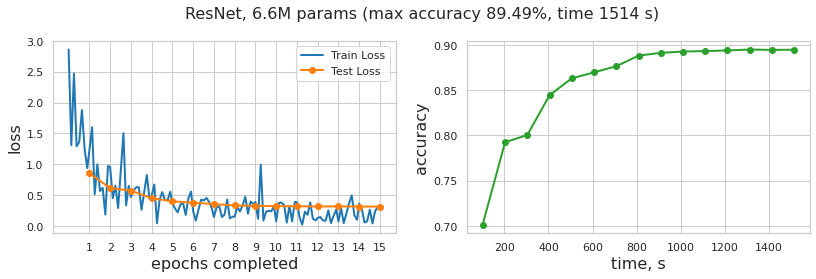

In [ ]:
resnet = ResNet().to(device)

wrapped_opt = optim.Adam(params=resnet.parameters(), amsgrad=True)
scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

resnet_train = train_test_plot(
    network=resnet,
    n_epochs=15,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_aug_loader,
    test_loader=test_cifar10_loader,
    title='ResNet, 6.6M params',
    scheduler=scheduler,
    log_interval=400
    )


Test set: Avg. loss: 2.3054, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 5.950569
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.858387
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.604350
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.806849
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.396026
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.129015
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.192142
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.849212

Test set: Avg. loss: 0.9085, Accuracy: 6767/10000 (68%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.528768
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.820028
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.943077
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.159148
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.745713
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.501056
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.876973
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.005975

Test set: Avg. loss: 0.6472, Accuracy: 7759/10000 (78%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.

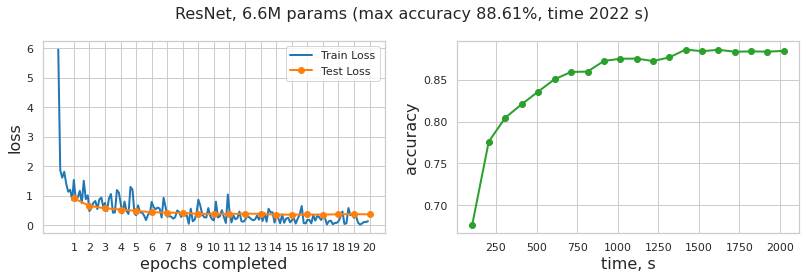

In [ ]:
resnet = ResNet().to(device)

wrapped_opt = optim.Adam(
    params=resnet.parameters(),
    lr=8e-5,
    betas=(0.85, 0.9996),
    amsgrad=True)
# scheduler = optim.lr_scheduler.ExponentialLR(wrapped_opt, 0.7, verbose=True)

resnet_train = train_test_plot(
    network=resnet,
    n_epochs=20,
    criterion=F.cross_entropy,
    optimizer=wrapped_opt,
    train_loader=train_cifar10_aug_loader,
    test_loader=test_cifar10_loader,
    title='ResNet, 6.6M params',
    # scheduler=scheduler,
    log_interval=400
    )

#### Total

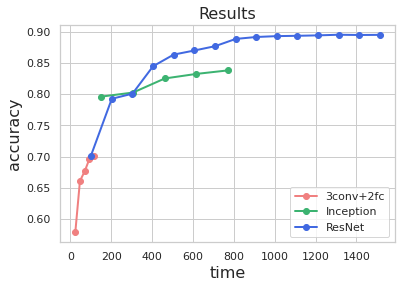

In [ ]:
inc = inception4_2_aug_train + inception4_2_aug_train_

plt.plot(conv3net2fc_train[-1], conv3net2fc_train[-2], marker='o',
         lw=2, color='lightcoral', label='3conv+2fc')
plt.plot(inc[-1], inc[-2], marker='o',
         lw=2, color='mediumseagreen', label='Inception')
plt.plot(resnet_train[-1], resnet_train[-2], marker='o',
         lw=2, color='royalblue', label='ResNet')

plt.xlabel('time', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.title('Results', fontsize=16)
plt.legend()

plt.savefig('comparisonCNN.svg', bbox_inches='tight')

plt.show()